In [1]:
import numpy as np
import common
import matplotlib.pyplot as plt
import gpflow
%load_ext autoreload
%autoreload 2
plt.rcParams["font.size"] = 30
np.random.seed(100)

/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Identity, NoneType, Kernel, InducingPoints], [Gaussian, Linear, NoneType, Sum, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [2]:
xs, ys = common.generate_observed_dataset()
real_xs, real_ys = common.generate_real_dataset()

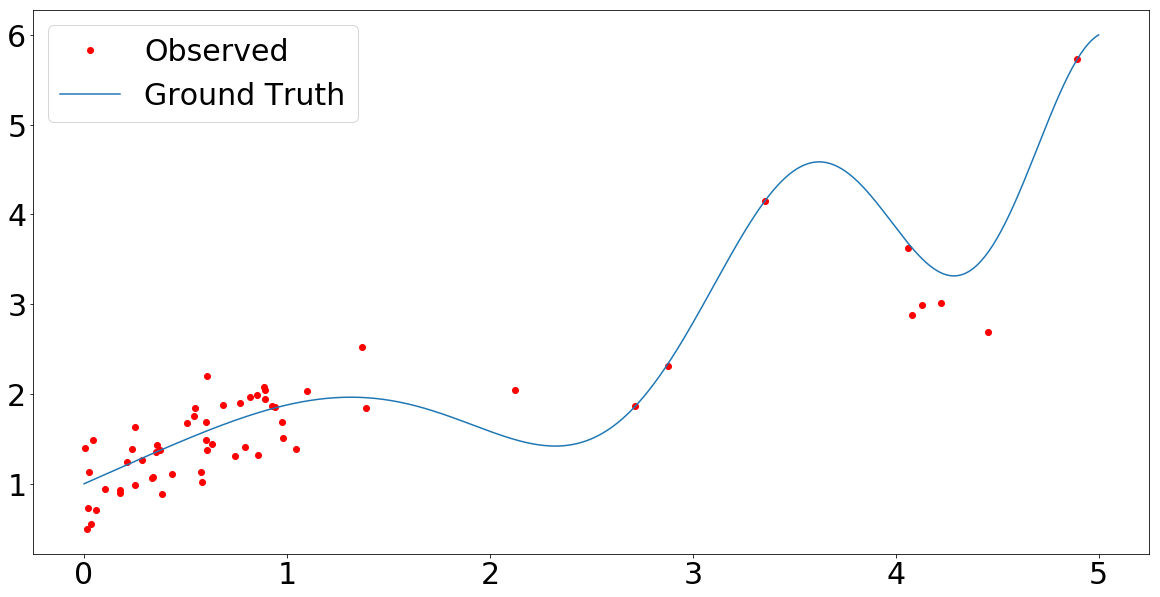

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(xs, ys, "ro", label="Observed")
plt.plot(real_xs, real_ys, label="Ground Truth")
plt.legend(loc="best")
plt.show()

In [4]:
xs = xs.reshape(-1, 1)
ys = np.array(ys).reshape(-1, 1)
print(xs.shape, ys.shape)

(60, 1) (60, 1)


In [5]:
with gpflow.defer_build():
    l = gpflow.likelihoods.StudentT()
    k = gpflow.kernels.Matern32(input_dim=1, variance=1, lengthscales=1.2)
    m = gpflow.models.GPMC(xs, ys, kern=k, likelihood=l)
    m.kern.lengthscales.prior = gpflow.priors.Gamma(1, 1)
    m.kern.variance.prior = gpflow.priors.Gamma(1, 1)
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPMC/V,Parameter,"N(0.0,1.0)",(none),True,"(60, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
GPMC/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,1.2
GPMC/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,1.0
GPMC/likelihood/scale,Parameter,None,+ve,True,(),True,1.0


In [6]:
# tensorflowを使うのでグラフの解釈を行う。
m.compile()

# 最適化器を作成
opt = gpflow.train.AdamOptimizer(0.01)

# 最適化を実行。事後確率最大化法（MAP)が行われる。
opt.minimize(m, maxiter=15) # Bayes推定時の初期値をMAPで決める。

s = gpflow.train.HMC()
# samples = s.sample(m, 100, epsilon=0.03, lmax=15)
samples = s.sample(m, 100, epsilon=0.05, lmax=15, thin=5, logprobs=False)#, verbose=True)

In [7]:
samples.head()

,GPMC/V,GPMC/kern/lengthscales,GPMC/kern/variance,GPMC/likelihood/scale
0,"[[1.4479577918058084], [0.46797993148287925], ...",0.895613,1.051310,1.119218
1,"[[1.4479577918058084], [0.46797993148287925], ...",0.895613,1.051310,1.119218
2,"[[1.4479577918058084], [0.46797993148287925], ...",0.895613,1.051310,1.119218
3,"[[1.4410108258299994], [0.43812091844545775], ...",0.892918,1.011065,1.131253
4,"[[1.3844229026169839], [0.4854267076003299], [...",0.867339,0.963233,1.183311


In [8]:
type(samples)

pandas.core.frame.DataFrame

In [9]:
xtest = np.linspace(0, 5, 1000)[:,None]
f_samples = []
for i, s in samples.iterrows():
    m.assign(s)
    f_samples.append(m.predict_f_samples(xtest, 5, initialize=True))
# f_samples = np.vstack(f_samples)

In [10]:
f_samples = np.vstack(f_samples)

In [11]:
f_samples.shape

(500, 1000, 1)

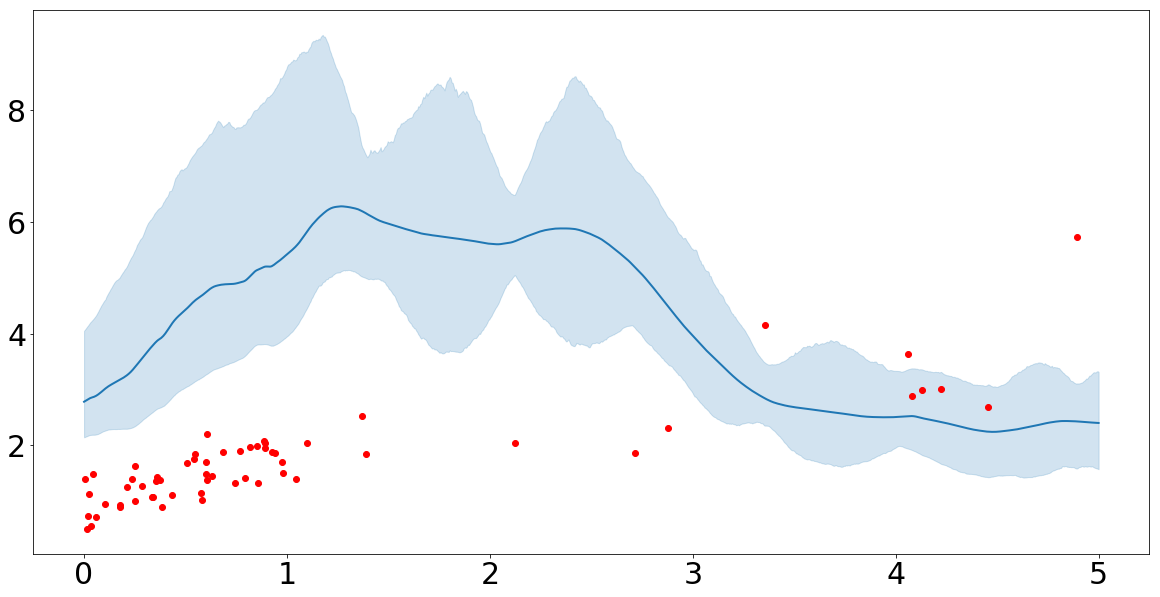

In [12]:
rate_samples = np.exp(f_samples[:, :, 0])
plt.figure(figsize=(20, 10))
plt.plot(xs, ys, "ro", label="Observed")
line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)
plt.show()

なんだこれは？上にずれてるぞ。